In [49]:
run_name = "comparative_analysis_cpu_100"

Note: this is an **oversubscribed** setup.

In [50]:
import os
import glob
from functools import reduce

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

## Configuration

1. Httperf
```json
{
    "vms": {
        "base_vm_id": 105,
        "clients": [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
        "type-unused": "NAT",
        "type": {
            "DR": {
                "prefix": "172.17.60.0/24",
                "iface": "eth1"
            }
        }
    },
    "httperf": {
        "vip": "172.17.60.201",
        "port": 80,
        "num-conns": 500,
        "num-calls": 1,
        "rate": 8,
        "ramp": 20,
        "iters": 1,
        "timeout": 3
    }
}
```

2. Host 10.10.10.107:80
```bash
./inf-loop-cpulimit.sh 50 2 # cpulimit=100%
```

## Client side analysis

In [52]:
# read in the data
data_dict = dict()

for d in glob.glob("./results/" + run_name + "/httperf_*_cpu_100+_nice_-10"):
    data_list = []
    for i in glob.glob(d + "/httperf_client_*.csv"):
        data_list.append(pd.read_csv(i, header=0, na_filter=False))
    
    data_frame = pd.DataFrame()
    if len(data_list) > 0:
        for i in list(data_list[0]):
            if not i.startswith('Response time'):
                data_frame[i] = reduce(lambda x, y: x + y, [data_list[j][i] for j in range(len(data_list))])
            else:
                data_frame[i] = reduce(lambda x, y: x + y, [data_list[j][i] for j in range(len(data_list))]) / len(data_list)
    data_dict[os.path.basename(d)] = data_frame

In [53]:
for d in data_dict:
    print(d)

httperf_unbalance_wlc_to3_fdb_rate_128_cpu_100+_nice_-10
httperf_unbalance_wrr_to3_fdb_rate_128_cpu_100+_nice_-10
httperf_unbalance_wlc_to3_rate_128_cpu_100+_nice_-10
httperf_unbalance_wrr_to3_rate_128_cpu_100+_nice_-10


### 1. Response rate analysis (percentiles)

In [56]:
plot_rrp_unbalance = dict()
plot_rrp_balance = dict()

for d in data_dict:
    if '_unbalance_' in d:
        plot_rrp_unbalance[d] = data_dict[d][['Rate', 'Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%', 'Response rate 80%', 'Response rate 90%', 
         'Response rate 95%', 'Response rate 98%', 'Response rate 99%', 'Response rate 100%']]
    if '_balance_' in d:
        plot_rrp_balance[d] = data_dict[d][['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%', 'Response rate 80%', 'Response rate 90%', 
         'Response rate 95%', 'Response rate 98%', 'Response rate 99%', 'Response rate 100%']]

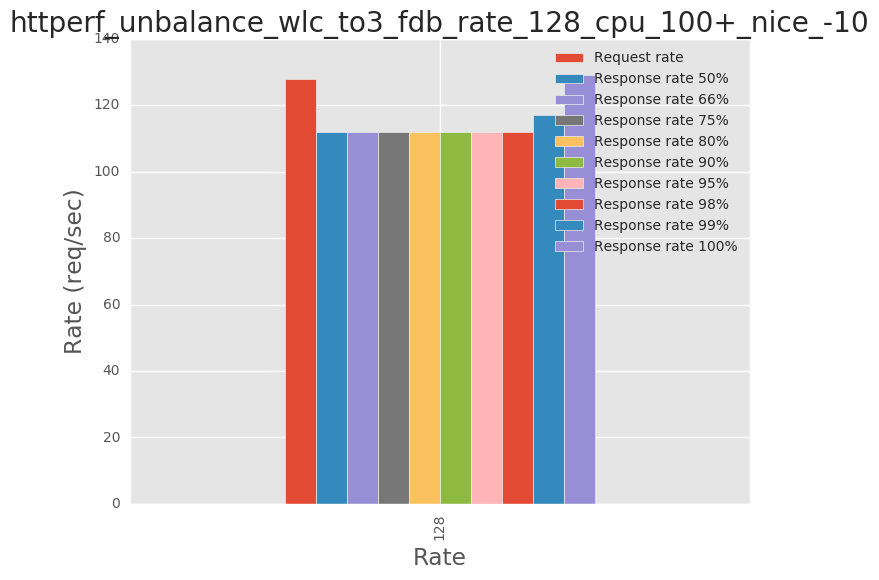

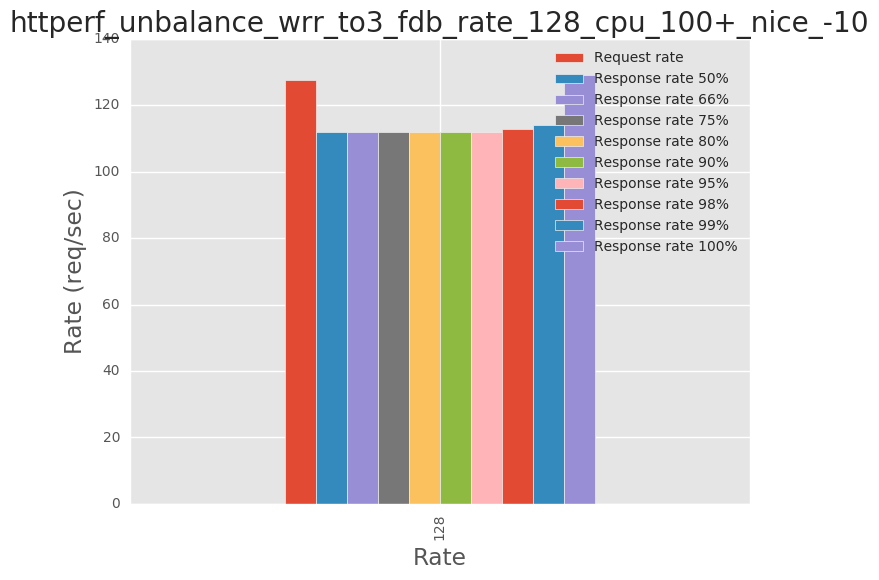

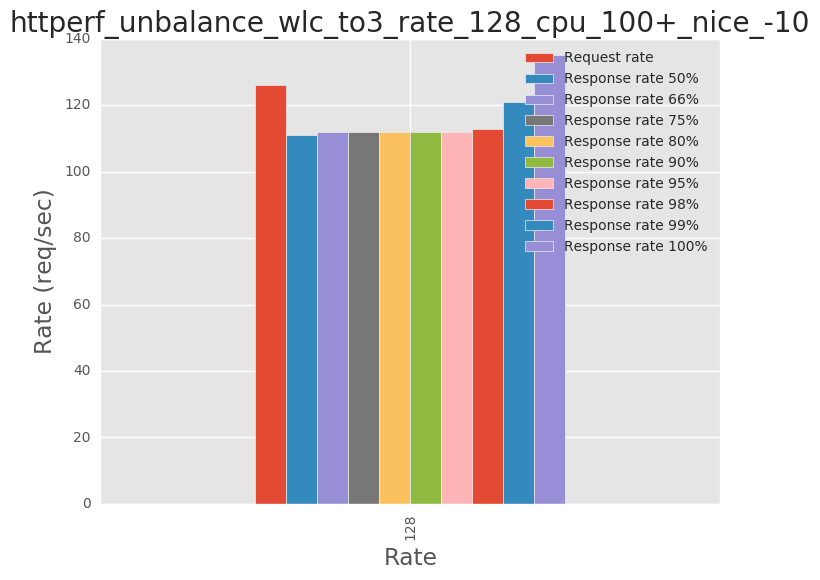

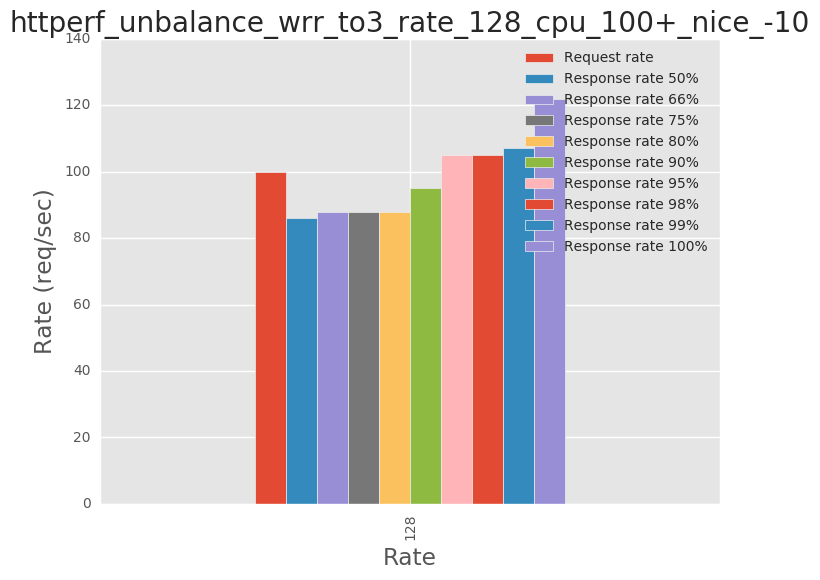

In [57]:
for d in data_dict:
    plot_rrp_unbalance[d].plot('Rate', kind='bar', title=d).set_ylabel('Rate (req/sec)')

### 2. Response time analysis (percentiles)

In [58]:
plot_rtp_unbalance = dict()
plot_rtp_balance = dict()

for d in data_dict:
    if '_unbalance_' in d:
        plot_rtp_unbalance[d] = data_dict[d][['Rate', 'Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%', 'Response time 80%', 'Response time 90%', 
          'Response time 95%', 'Response time 98%', 'Response time 99%', 'Response time 100%']]
    if '_balance_' in d:
        plot_rtp_balance[d] = data_dict[d][['Rate', 'Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%', 'Response time 80%', 'Response time 90%', 
          'Response time 95%', 'Response time 98%', 'Response time 99%', 'Response time 100%']]

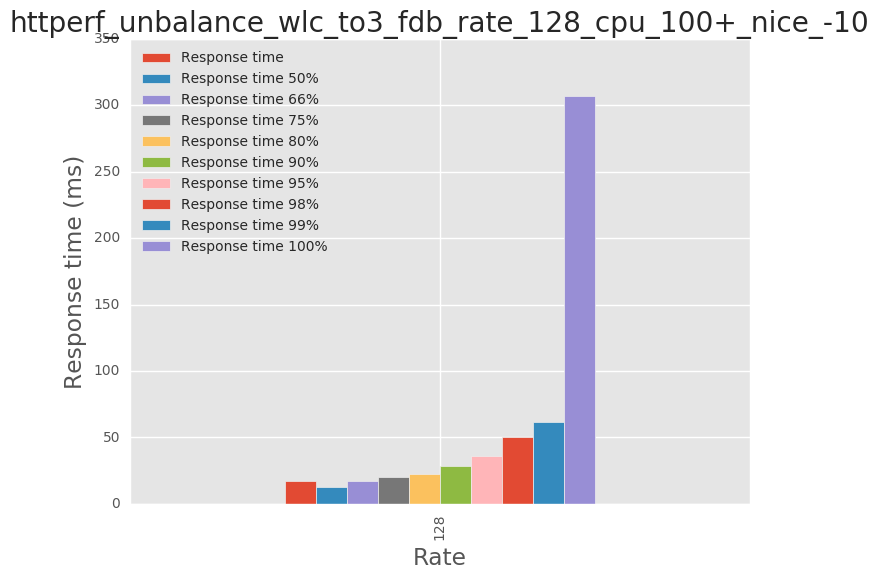

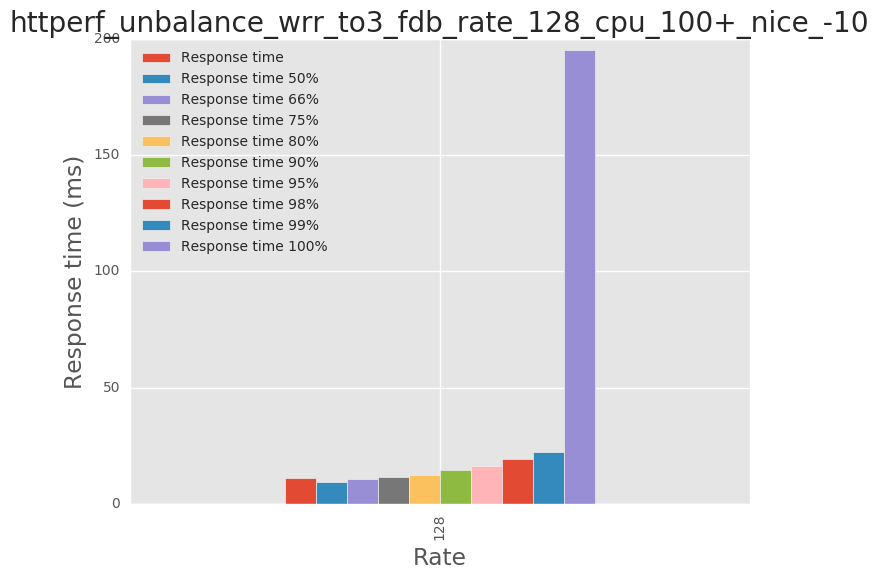

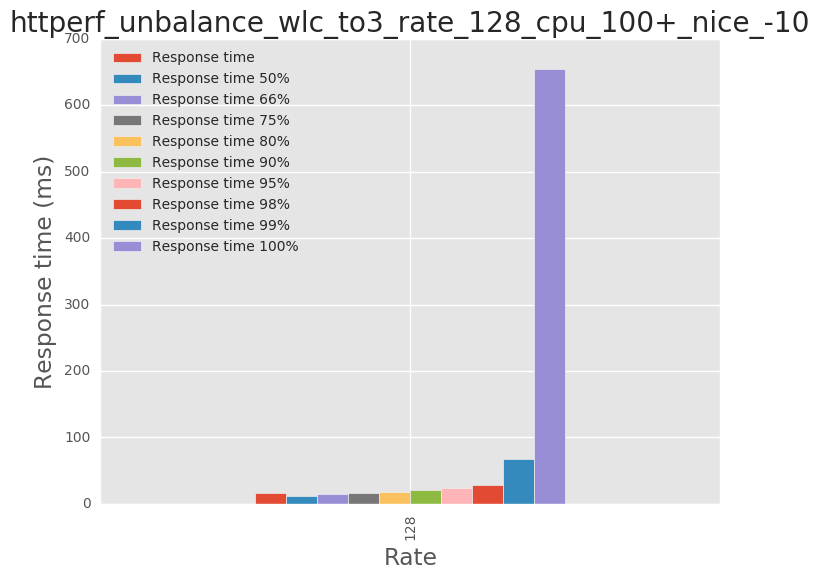

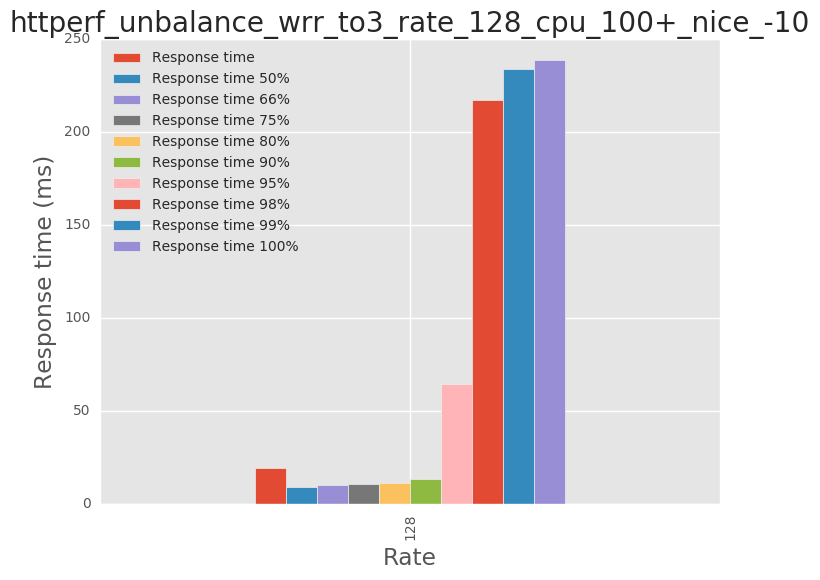

In [59]:
for d in data_dict:
    plot_rtp_unbalance[d].plot('Rate', kind='bar', title=d).set_ylabel('Response time (ms)')

#### WRR comparison chart

In [60]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_rate_128_cpu_100+_nice_-10']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,128,19.3125,9.1875,10.0625,10.5,11.125,13.25,64.5,216.9375,234.0,238.875


In [61]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_fdb_rate_128_cpu_100+_nice_-10']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,128,11.10625,9.5,10.625,11.625,12.1875,14.5625,16.4375,19.4375,22.5,195.0


In [62]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_fdb_rate_128_cpu_100+_nice_-10'] - plot_rtp_unbalance['httperf_unbalance_wrr_to3_rate_128_cpu_100+_nice_-10']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,0,-8.20625,0.3125,0.5625,1.125,1.0625,1.3125,-48.0625,-197.5,-211.5,-43.875


#### WLC comparison chart

In [63]:
plot_rtp_unbalance['httperf_unbalance_wlc_to3_rate_128_cpu_100+_nice_-10']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,128,16.9375,12.375,14.5,16.1875,17.5,20.75,24.375,28.75,68.0,654.4375


In [64]:
plot_rtp_unbalance['httperf_unbalance_wlc_to3_fdb_rate_128_cpu_100+_nice_-10']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,128,17.18125,13.0,17.0,20.0625,22.25,28.4375,35.875,49.9375,61.3125,307.0


In [65]:
plot_rtp_unbalance['httperf_unbalance_wlc_to3_fdb_rate_128_cpu_100+_nice_-10'] - plot_rtp_unbalance['httperf_unbalance_wlc_to3_rate_128_cpu_100+_nice_-10']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,0,0.24375,0.625,2.5,3.875,4.75,7.6875,11.5,21.1875,-6.6875,-347.4375


#### WRR-FDB vs. WLC

In [66]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_fdb_rate_128_cpu_100+_nice_-10'] - plot_rtp_unbalance['httperf_unbalance_wlc_to3_rate_128_cpu_100+_nice_-10']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,0,-5.83125,-2.875,-3.875,-4.5625,-5.3125,-6.1875,-7.9375,-9.3125,-45.5,-459.4375


In [41]:
plot_rtp_unbalance['httperf_unbalance_wrr_to3_fdb_rate_128_cpu_100+_nice_-10'] - plot_rtp_unbalance['httperf_unbalance_wlc_to3_fdb_rate_128_cpu_100+_nice_-10']

,Rate,Response time,Response time 50%,Response time 66%,Response time 75%,Response time 80%,Response time 90%,Response time 95%,Response time 98%,Response time 99%,Response time 100%
0,0,-6.075,-3.5,-6.375,-8.4375,-10.0625,-13.875,-19.4375,-30.5,-38.8125,-112.0


### 3. Error analysis

In [70]:
plot_err_unbalance = pd.DataFrame()
plot_err_balance = pd.DataFrame()

for d in data_dict:
    if '_unbalance_' in d:
        plot_err_unbalance[d] = data_dict[d]['Error']
    if '_balance_' in d:
        plot_err_balance[d] = data_dict[d]['Error']
        
if '_unbalance_' in d:
    plot_err_unbalance['Rate'] = data_dict[d]['Rate']
if '_balance_' in d:
    plot_err_balance['Rate'] = data_dict[d]['Rate']

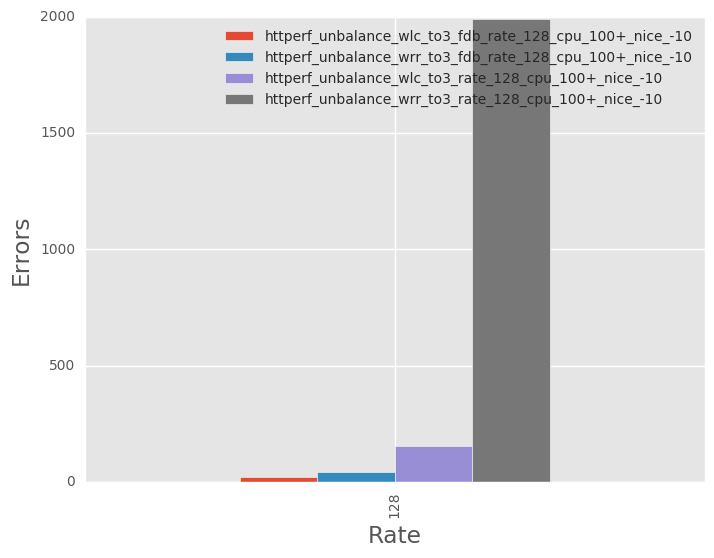

In [72]:
plot_err_unbalance.plot('Rate', kind='bar').set_ylabel('Errors')

## Server side analysis

In [42]:
# read in the data
stats_dict = dict()

for d in glob.glob("./results/" + run_name + "/httperf_*_cpu_100+_nice_-10"):
    stats_frame = pd.read_csv(d + "/httperf_server_stats.csv", header=0, na_filter=False)
    for i in ['Connections', 'Packets', 'Bytes (K)']:
        stats_frame[i + ' Ratio (%)'] = stats_frame[i] / sum(stats_frame[i]) * 100
    
    stats_dict[os.path.basename(d)] = stats_frame

### 1. Connections ratio (%)

In [43]:
plot_connections_unbalance = pd.DataFrame()
plot_connections_balance = pd.DataFrame()

plot_connections_unbalance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
plot_connections_balance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
    
for d in stats_dict:
    if '_unbalance_' in d:
        plot_connections_unbalance['Connections Ratio (%) - ' + d] = stats_dict[d]['Connections Ratio (%)']
    if '_balance_' in d:
        plot_connections_balance['Connections Ratio (%) - ' + d] = stats_dict[d]['Connections Ratio (%)']

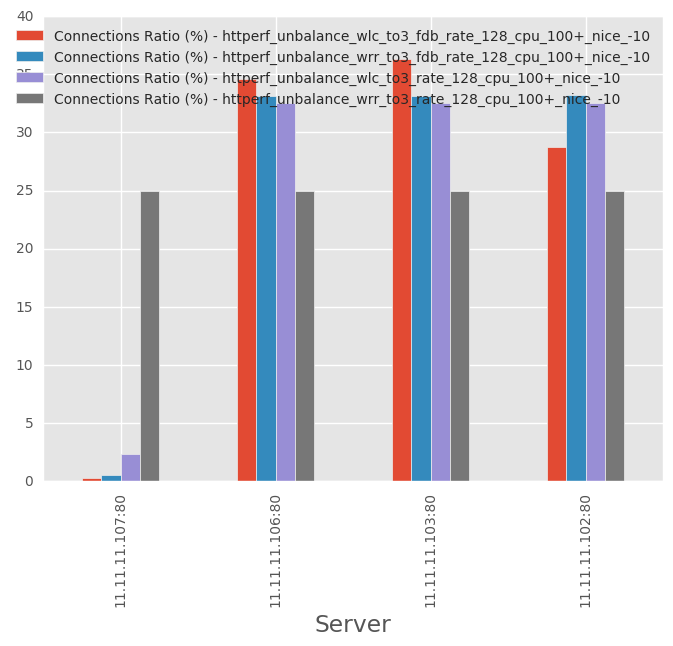

In [44]:
plot_connections_unbalance.plot('Server', kind='bar')

### 2. Packets ratio (%)

In [45]:
plot_packets_unbalance = pd.DataFrame()
plot_packets_balance = pd.DataFrame()

plot_packets_unbalance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
plot_packets_balance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
    
for d in stats_dict:
    if '_unbalance_' in d:
        plot_packets_unbalance['Packets Ratio (%) - ' + d] = stats_dict[d]['Packets Ratio (%)']
    if '_balance_' in d:
        plot_packets_balance['Packets Ratio (%) - ' + d] = stats_dict[d]['Packets Ratio (%)']

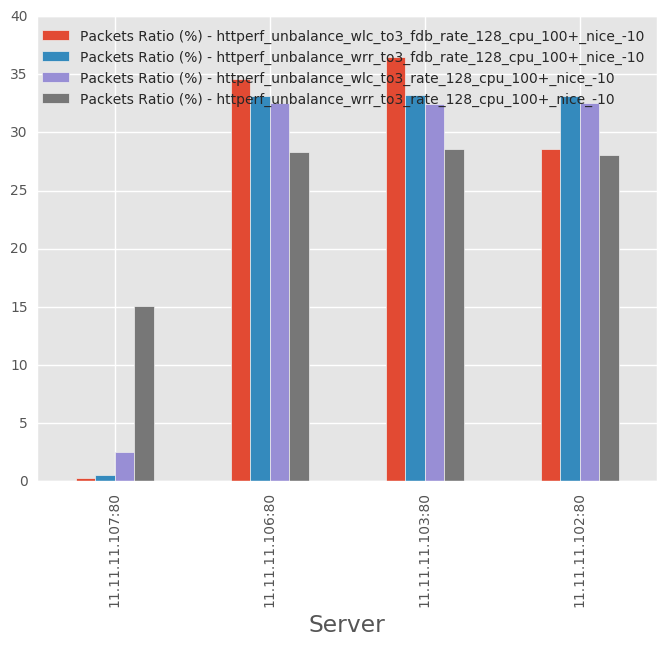

In [46]:
plot_packets_unbalance.plot('Server', kind='bar')

### 3. Bytes ratio (%)

In [47]:
plot_bytes_unbalance = pd.DataFrame()
plot_bytes_balance = pd.DataFrame()

plot_bytes_unbalance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
plot_bytes_balance['Server'] = stats_dict[list(stats_dict.keys())[0]]['Server']
    
for d in stats_dict:
    if '_unbalance_' in d:
        plot_bytes_unbalance['Bytes (K) Ratio (%) - ' + d] = stats_dict[d]['Bytes (K) Ratio (%)']
    if '_balance_' in d:
        plot_bytes_balance['Bytes (K) Ratio (%) - ' + d] = stats_dict[d]['Bytes (K) Ratio (%)']

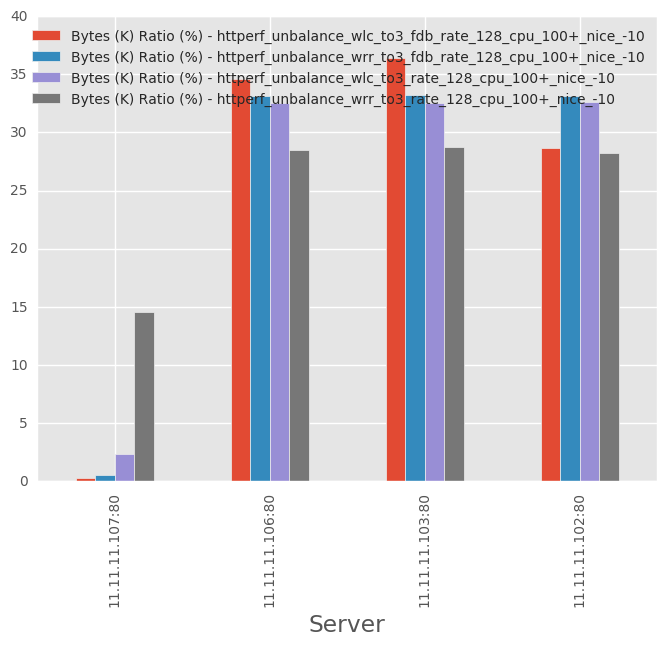

In [48]:
plot_bytes_unbalance.plot('Server', kind='bar')